In [44]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize

In [45]:
!pip install opensimplex

In [46]:
class MRIDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(256, 256), noise_type=None):

        self.data_dir = data_dir
        self.transform = transform
        self.target_size = target_size
        self.noise_type = noise_type
        self.image_paths = self._load_image_paths()
    
    def _load_image_paths(self):

        image_paths = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith(".png"):
                    image_paths.append(os.path.join(root, file))
        return sorted(image_paths)
    
    def __len__(self):
        return len(self.image_paths)
    
    def _add_noise(self, image):
        if self.noise_type == 'coarse':
            # Coarse noise: Low-resolution Gaussian noise
            noise = np.random.normal(0, 0.2, size=(16, 16))
            noise = np.array(Image.fromarray(noise).resize(self.target_size, resample=Image.BILINEAR))
            return image + noise
        elif self.noise_type == 'simplex':
            # Simplex noise: Structured noise
            from opensimplex import OpenSimplex
            simplex = OpenSimplex(seed=42)
            noise = np.zeros(self.target_size)
            scale = 1.0 / 64.0
            for i in range(self.target_size[0]):
                for j in range(self.target_size[1]):
                    noise[i, j] = simplex.noise2(i * scale, j * scale)
            return image + noise
        else:
            return image

    def __getitem__(self, idx):
        # Load the image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")  # Load as grayscale
        
        # Resize image
        image = image.resize(self.target_size, resample=Image.BILINEAR)
        
        # Convert to NumPy array and normalize to [0, 1]
        image = np.array(image, dtype=np.float32) / 255.0
        
        # Add noise if applicable
        if self.noise_type:
            image = self._add_noise(image)
        
        # Convert back to PIL Image if transform is applied
        if self.transform:
            image = Image.fromarray((image * 255).astype(np.uint8))  # Scale back to [0, 255]
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32)
        
        # Expand to (C, H, W) format (channel dimension)
        image = image.unsqueeze(0) if not self.transform else image
        
        # Label is always 0 (healthy)
        label = 0
        
        return image, label


    def plot_samples(self, num_samples=8):
        if num_samples % 4 != 0:
            raise ValueError("Number of samples must be a multiple of 4.")
        
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 10))
        
        for i in range(num_samples):
            idx = np.random.randint(len(self.image_paths))
            image, label = self[idx]
            
            # Convert tensor to numpy array for plotting
            image_np = image.squeeze(0).numpy()
            
            # Display the image
            axes[i].imshow(image_np, cmap='gray')
            axes[i].set_title(f"Label: {'Healthy'}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()


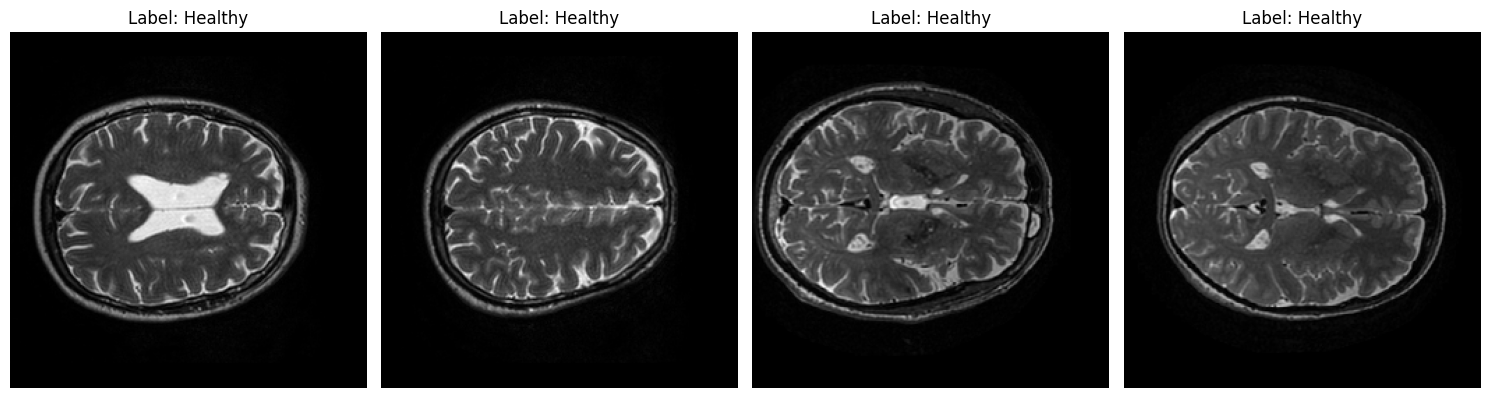

In [47]:
ixit = MRIDataset("/kaggle/input/ixit2-slices", transform)
ixit.plot_samples(4)

In [48]:
class BraTSDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(256, 256)):
        self.data_dir = data_dir
        self.transform = transform
        self.target_size = target_size
        self.image_paths, self.mask_paths = self._load_paths()
    
    def _load_paths(self):
        image_paths = []
        mask_paths = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith("_t2.nii"):
                    image_paths.append(os.path.join(root, file))
                    mask_paths.append(os.path.join(root, file.replace("_t2.nii", "_seg.nii")))
        return sorted(image_paths), sorted(mask_paths)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load T2-weighted image and mask
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()
        
        # Extract the middle slice along the z-axis
        z_index = image.shape[-1] // 2
        image = image[:, :, z_index]  # Extract 2D slice
        mask = mask[:, :, z_index]   # Extract 2D slice
    
        # Normalize image to [0, 1]
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
        # Resize image and mask to target size
        image = resize(image, self.target_size, order=1, mode='reflect', anti_aliasing=True)
        mask = resize(mask, self.target_size, order=0, mode='reflect', anti_aliasing=False)
    
        # Convert NumPy arrays back to PIL images for transformation
        image = Image.fromarray((image * 255).astype(np.uint8))
        mask = Image.fromarray((mask * 255).astype(np.uint8))
    
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else:
            # Convert to tensors
            image = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0)  # Add channel dim
            mask = torch.tensor(np.array(mask), dtype=torch.float32)
    
        return image, mask


    def plot_samples(self, num_samples=4):
        if num_samples % 2 != 0:
            raise ValueError("Number of samples must be even.")
        
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
        
        for i in range(num_samples):
            idx = np.random.randint(len(self.image_paths))
            image, mask = self[idx]
            
            # Convert tensors to numpy arrays for plotting
            image_np = image.squeeze(0).numpy() if isinstance(image, torch.Tensor) else image
            mask_np = mask.squeeze(0).numpy() if len(mask.shape) == 3 else mask
            
            # Display image
            axes[0, i].imshow(image_np, cmap='gray')
            axes[0, i].set_title("T2 Image")
            axes[0, i].axis('off')
            
            # Display corresponding mask
            axes[1, i].imshow(mask_np, cmap='gray')
            axes[1, i].set_title("Segmentation Mask")
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()



In [49]:
data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
dataset = BraTSDataset(data_dir=data_dir, transform=transform)

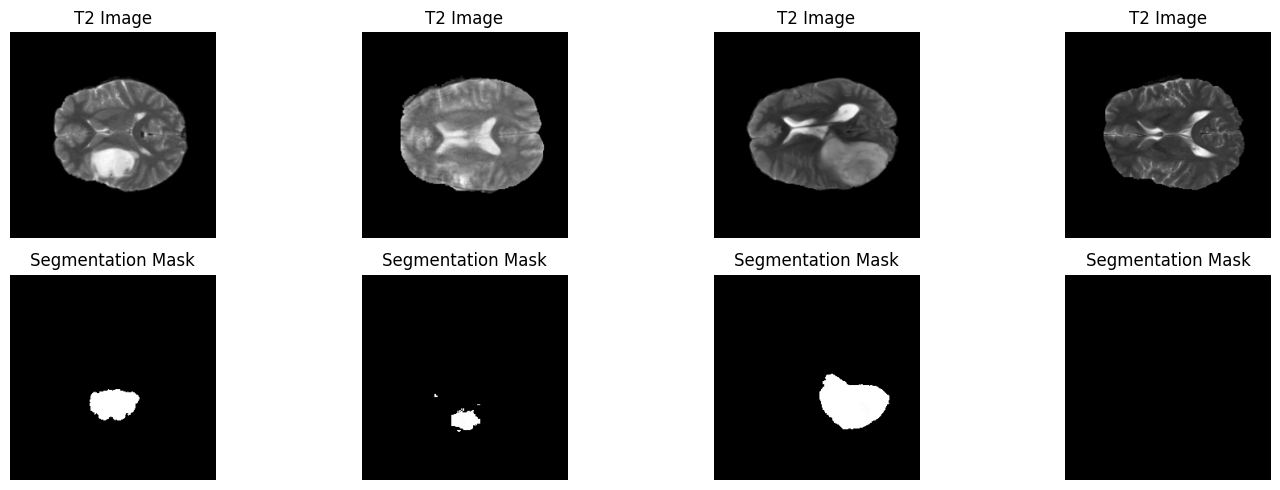

In [50]:
dataset.plot_samples()